In [3]:
import pandas as pd
import fiona
import geopandas as gp
from geopandas import GeoDataFrame
from shapely.geometry import Point
import numpy as np
import statsmodels.api as sm
import matplotlib
import matplotlib.pylab as pl
from pylab import rcParams
import matplotlib.pyplot as plt

import csv

from datetime import datetime
from dateutil.parser import parse

%matplotlib inline

# Importing 311 data for zip code 11201

In [315]:
data = pd.read_csv('data/311_Service_Requests_11201_Mar16_to_Feb17.csv')
print("There were", len(data), "complaints in zip code 11201 between March 1, 2016 and February 28, 2017.")
data.drop(['Agency Name', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough',
       'School Name', 'School Number', 'School Region', 'School Code',
       'School Phone Number', 'School Address', 'School City', 'School State',
       'School Zip', 'School Not Found', 'School or Citywide Complaint',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Garage Lot Name', 'Ferry Direction',
       'Ferry Terminal Name', 'Location'], axis=1, inplace=True)

There were 16371 complaints in zip code 11201 between March 1, 2016 and February 28, 2017.


# 1. Calculating time to respond to complaints

In [316]:
data['Created Date'] = pd.to_datetime(data['Created Date'])
data['Closed Date'] = pd.to_datetime(data['Closed Date'])
data['response_time'] = data['Closed Date'] - data['Created Date']
data.head(3)

,Unique Key,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Latitude,Longitude,response_time
0,35334085,2017-01-25 08:39:40,2017-01-26 00:16:00,DOT,Street Condition,Pothole,40.701527,-73.986750,0 days 15:36:20
1,32804478,2016-03-01 12:53:57,2016-03-01 14:23:06,NYPD,Noise - Residential,Banging/Pounding,40.695428,-73.981176,0 days 01:29:09
2,32805110,2016-03-01 06:58:49,2016-03-03 06:51:05,HPD,HEAT/HOT WATER,APARTMENT ONLY,40.691174,-73.991641,1 days 23:52:16


Median time to respond is 1 day, 2 hours, 2 minutes, and 27.5 seconds. Average is much higher at over 10 days because of an upper tail.

In [317]:
def response_stats(df):
    print("DESCRIPTIVE STATS FOR THE RAW DATA:")
    print(df['response_time'].describe())
    print('--------')
    print("DESCRIPTIVE STATS FOR THE CLEANED DATA:")
    df_cleaned = df[df['response_time'] < np.mean(df['response_time'])+3*np.std(df['response_time'])]
    df_cleaned = df_cleaned[df_cleaned['response_time'] > '0 days']
    print(df_cleaned['response_time'].describe())
    print('--------')
    print("There were", len(df[df['response_time'] > np.mean(df['response_time'])+3*np.std(df['response_time'])])\
      , "upper outliers removed.")
    print("There were", len(df[df['response_time'] < '0 days']), "rows removed with response times below zero.")
    
response_stats(data)

DESCRIPTIVE STATS FOR THE RAW DATA:
count                      15842
mean     10 days 03:45:07.030109
std      55 days 15:03:28.768216
min         -5658 days +23:06:34
25%       0 days 02:22:00.250000
50%       1 days 02:02:27.500000
75%       6 days 20:43:51.750000
max            500 days 03:13:45
Name: response_time, dtype: object
--------
DESCRIPTIVE STATS FOR THE CLEANED DATA:
count                      14950
mean      8 days 22:01:52.217123
std      21 days 16:33:04.874078
min              0 days 00:00:01
25%       0 days 03:00:47.500000
50%       1 days 06:06:44.500000
75%              6 days 22:50:45
max            176 days 22:38:02
Name: response_time, dtype: object
--------
There were 125 upper outliers removed.
There were 171 rows removed with response times below zero.


Removing outliers (by removing values more than 3 standard deviations above the mean and values less than 0) brings the mean down (because of the big upper tail) but brings the median up, apparently because there were many values below zero (probably errors in the data) that weren't as extreme as the upper outliers. This is helpful to determine what's typical for 311 responses but NOT an appropriate transformation of 311 data for publishing or reporting without explanation. The City is responsible for responses to every 311 complaint and they should all be reported on. Removing upper outliers is probably useful for comparing geographic areas or stats over time, to get a sense of how the bulk of response behavior varies over space and time.

Before the cleaning, there were 171 rows where the closed date was before the created date. This is impossible, meaning one or both of these dates was entered wrong. Need to assess data collection practices.

By looking at the data below, we can see that most of the incorrectly reported complaints are from DOT and are of the type "Street Light Condition". Time to go talk to the people who are recording these complaints. Also worth checking in with DOHMH about the Rodent complaints.

In [318]:
data[data['response_time'] < '0 days']

,Unique Key,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Latitude,Longitude,response_time
188,32848791,2016-03-07 12:28:00,2016-03-04 12:28:00,DOT,Street Light Condition,Street Light Out,40.687315,-73.991941,-3 days +00:00:00
193,32849104,2016-03-07 00:00:00,2016-03-04 16:21:36,DOHMH,Rodent,Rat Sighting,40.687145,-73.989457,-3 days +16:21:36
233,32854247,2016-03-07 00:00:00,2016-03-04 16:21:36,DOHMH,Rodent,Rat Sighting,40.687145,-73.989457,-3 days +16:21:36
266,32862470,2016-03-08 00:00:00,2016-03-04 16:21:36,DOHMH,Rodent,Rat Sighting,40.687145,-73.989457,-4 days +16:21:36
487,32900887,2016-03-14 12:28:00,2016-03-11 12:28:00,DOT,Street Light Condition,Street Light Out,40.695075,-73.990090,-3 days +00:00:00
504,32903928,2016-03-14 12:28:00,2016-03-11 12:28:00,DOT,Street Light Condition,Street Light Out,40.696132,-73.996412,-3 days +00:00:00
505,32903929,2016-03-14 12:28:00,2016-03-11 12:28:00,DOT,Street Light Condition,Street Light Out,40.693439,-73.996718,-3 days +00:00:00
526,32907148,2016-03-14 12:27:00,2016-03-11 12:27:00,DOT,Street Light Condition,Street Light Out,40.697227,-73.992124,-3 days +00:00:00
985,33006939,2016-03-28 15:37:00,2016-03-25 15:37:00,DOT,Street Light Condition,Street Light Out,40.688174,-73.983987,-3 days +00:00:00
1258,33054709,2016-04-04 13:44:00,2016-04-01 13:44:00,DOT,Street Light Condition,Street Light Out,40.698502,-73.986970,-3 days +00:00:00


NOTE: these upper outliers and sub-zero values are NOT removed for later analyses about complaints over time or across geographies or per agency.

# 2. Counting complaints per agency

In [8]:
# counting the complaints for one agency

DOT = data[data['Agency']=='DOT']
len(DOT)

3172

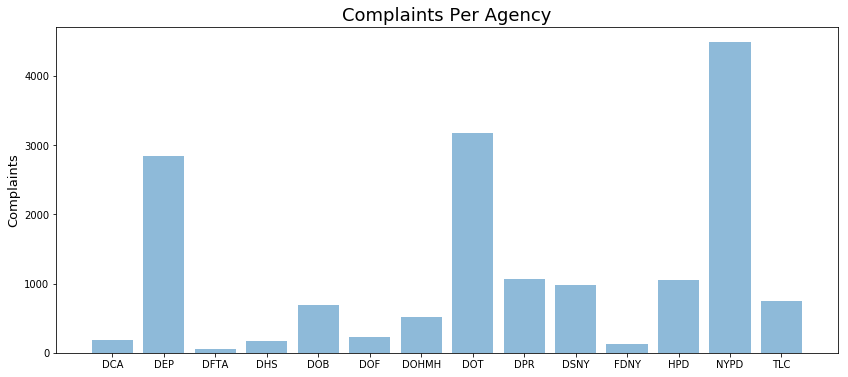

In [175]:
# counting the complaints for all agencies

def plot_complaints_per_agency(df):
    agency1 = df.groupby('Agency')
    agency = pd.DataFrame(agency1['Agency'].apply(np.size))
    agency.rename(columns = {'Agency':'Number_of_Calls'}, inplace = True)
    # next line eliminates agencies with very few complaints
    agency = agency[agency['Number_of_Calls'] > (np.max(agency['Number_of_Calls'])/100)]
    agency['City_Agency'] = agency.index
    
    objects = agency['City_Agency']
    y_pos = np.arange(len(objects))
    number = agency['Number_of_Calls']

    plt.figure(figsize=(14,6))
    plt.bar(y_pos, number, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Complaints', fontsize=13)
    plt.title('Complaints Per Agency', fontsize=18)
    
plot_complaints_per_agency(data)

Fig. 1 Complaints Per Agency in Zip Code 11201 from March 1, 2016 to February 28, 2017.

## Agency acronym keys:
- DCA: Consumer Affairs
- DEP: Environmental Protection
- DFTA: for the Aging
- DOB: Buildings
- DOF: Finance
- DOHMH: Health and Mental Hygiene
- DOT: Transportation
- DPR: Parks and Recreation
- DSNY: Sanitation
- EDC: Economic Development Corporation
- FDNY: Fire
- HPD: Housing Preservation and Development
- NYPD: Police
- TLC: Tax and Limousine Commission

# 3. Plotting complaints per day, per month, and weekly seasonality

## Per Day

DESCRIPTIVE STATISTICS ON # OF COMPLAINTS PER DAY:        #_of_Complaints
count       365.000000
mean         44.852055
std          15.093483
min           1.000000
25%          36.000000
50%          44.000000
75%          55.000000
max          93.000000
--------
DAY(S) WITH THE MOST COMPLAINTS:             #_of_Complaints
2016-05-07               93
2016-10-25               93


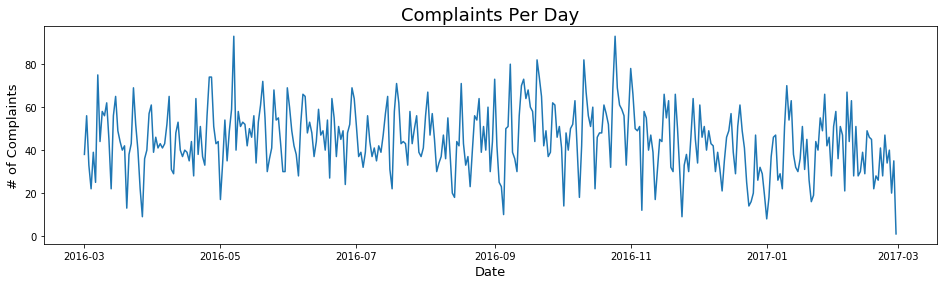

In [319]:
def complaints_per_day(df):
    grouped = df.groupby(df['Created Date'].apply(lambda x: x.date()))
    daily = pd.DataFrame(grouped['Unique Key'].count())
    daily.index = pd.to_datetime(daily.index)
    daily.rename(columns={'Unique Key': '#_of_Complaints'}, inplace=True)
    daily.index.name = None
    
    plt.figure(figsize=(16,4))
    plt.ylabel('# of Complaints', fontsize=13)
    plt.xlabel('Date', fontsize=13) # may need to change this to make it more clear
    plt.title('Complaints Per Day', fontsize=18)
    plt.plot(daily)
    
    print("DESCRIPTIVE STATISTICS ON # OF COMPLAINTS PER DAY:",
          daily.describe())
    print('--------')
    print("DAY(S) WITH THE MOST COMPLAINTS:", daily[daily["#_of_Complaints"]==np.max(daily["#_of_Complaints"])])
    
complaints_per_day(data)

Fig. 2 Number of 311 Complaints Per Day in Zip Code 11201 from March 1, 2016 to February 28, 2017.

## Per Month

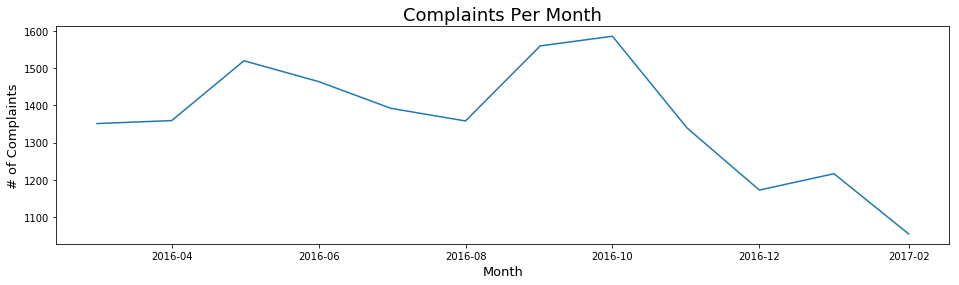

In [13]:
grouped = data.groupby(data['Created Date'].apply(lambda x: x.date()))
daily = pd.DataFrame(grouped['Unique Key'].count())
daily.index = pd.to_datetime(daily.index)
daily.rename(columns={'Unique Key': '#_of_Complaints'}, inplace=True)
daily.index.name = None

monthly = daily['#_of_Complaints'].resample('MS').sum()

plt.figure(figsize=(16,4))
plt.ylabel('# of Complaints', fontsize=13)
plt.xlabel('Month', fontsize=13)
plt.title('Complaints Per Month', fontsize=18)
plt.plot(monthly)

Fig. 3 Number of 311 Complaints Per Month in Zip Code 11201 from March 2016 to February 2017. Clear decline between October and February; matches Trend subplot in Fig 4.

## Showing weekly seasonality of complaints.

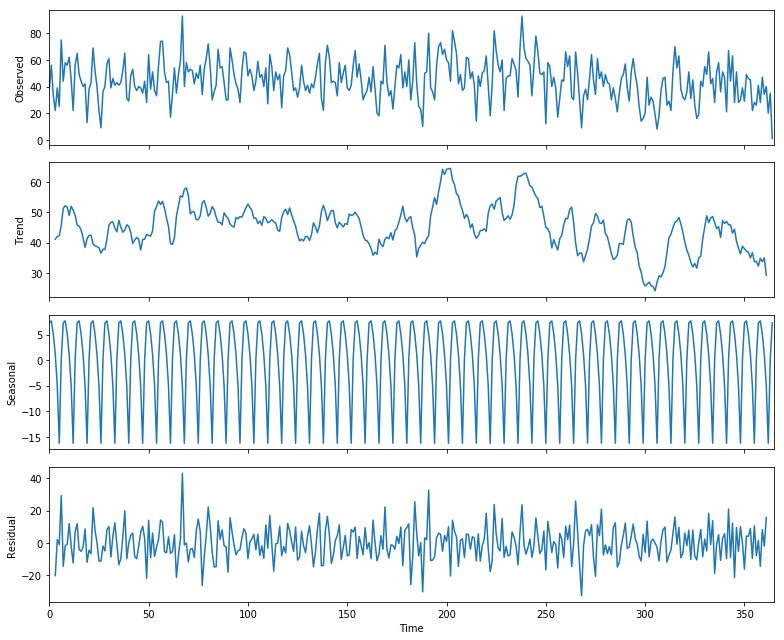

In [14]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(daily.values, freq=7, model='additive')
fig = decomposition.plot()

Fig. 4 Showing seasonality of complaints. The important parameter to note is frequency=7, or 7 days (one week). Subplot labeled "Seasonal" shows the weekly cycle.

### Grouping by day of the week shows lower average complaints per day on weekends and highest mid week.

In [15]:
def day_of_week(df):
    # this groups complaints by date
    grouped = df.groupby(df['Created Date'].apply(lambda x: x.date()))
    daily = pd.DataFrame(grouped['Unique Key'].count())
    daily.index = pd.to_datetime(daily.index)
    daily.rename(columns={'Unique Key': '#_of_Complaints'}, inplace=True)
    daily.index.name = None
    daily['date'] = daily.index
    daily['day_of_week'] = daily['date'].dt.dayofweek # Monday=0, Sunday=6

    # this groups dates by day of the week
    grouped_again = daily.groupby(daily['day_of_week'])
    days = pd.DataFrame(grouped_again['#_of_Complaints'].mean())
    days.rename(columns={'#_of_Complaints': 'ave_complaints'}, inplace=True)
    days.index = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
    return days

day_of_week(data)

,ave_complaints
Monday,45.096154
Tuesday,51.226415
Wednesday,52.923077
Thursday,49.961538
Friday,46.076923
Saturday,39.865385
Sunday,28.692308


# 4. Grouping Complaint Types

In [366]:
def group_by_complaint_type(df):
    ctype1 = df.groupby('Complaint Type')
    ctype = pd.DataFrame(ctype1['Unique Key'].apply(np.size))
    ctype.rename(columns = {'Unique Key':'Number_of_Calls'}, inplace = True)
    ctype.sort_values(by='Number_of_Calls', axis=0, ascending=False, inplace=True)
    ctype.index.name = None
    ctype2 = ctype[ctype['Number_of_Calls'] > 10]
    print("There are", len(ctype), "different complaint types of which", len(ctype2), "have at least 10 complaints.")
    print('----------')
    print(ctype2.head(10))
    
group_by_complaint_type(data)

There are 154 different complaint types of which 94 have at least 10 complaints.
----------
                         Number_of_Calls
Noise                               1753
Illegal Parking                     1472
Noise - Residential                 1121
Street Condition                     982
Broken Muni Meter                    707
Street Light Condition               691
Noise - Street/Sidewalk              489
HEAT/HOT WATER                       433
Taxi Complaint                       431
Noise - Commercial                   399


# 5. Mapping with GeoPandas

In [17]:
crs = {'init': 'epsg:4326'}

In [28]:
geometry = [Point(xy) for xy in zip(data.Longitude, data.Latitude)]
geo_data = data.drop(['Longitude', 'Latitude'], axis=1)
geo_df = GeoDataFrame(data, crs=crs, geometry=geometry)
geo_df = geo_df[geo_df['Longitude']<-73.96] # removing one point that was way outside the zip code
geo_df.head(3)

In [ ]:
# getting shapefile of zip codes after downloading from:
# https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u

zips = gp.GeoDataFrame.from_file('data/zip_codes/ZIP_CODE_040114.shp')
metrozip = zips[zips['ZIPCODE']=='11201']
metrozip.crs = crs

In [ ]:
metrozip.crs == geo_df.crs

In [ ]:
f, ax = plt.subplots(figsize=(9,9))
geo_df.plot(ax = ax, marker='*', color='green', markersize=4)
# ax.legend(loc = 'best', fontsize=12)
ax.set_xlim(-74.004, -73.973)
ax.set_ylim(40.682, 40.707)
ax.set_title('All complaints in zip code 11201', fontsize = 22)
ax.set_xlabel('Longitude', fontsize = 16)
ax.set_ylabel('Latitude', fontsize = 16)

# Looking at Spatial Distribution of Noise Complaints

In [27]:
noises = geo_df.loc[geo_df['Complaint Type'].isin(['Noise', 'Noise - Residential', 'Noise - Street/Sidewalk', \
              'Noise - Commercial', 'Noise - Vehicle', 'Noise - Helicopter'])]
print("There are", len(noises), "complaints having to do with various kinds of noise.")
noises.head()

In [ ]:
# exporting to csv so I can work with it in Carto

csv_file_path = "data/noise_data.csv"

pd.DataFrame.to_csv(noises, path_or_buf=csv_file_path)

In [355]:
# to embed Carto map in Jupyter Notebook:

# BASEURL = 'https://chrisstreich.carto.com/builder/355f6baf-7e7d-404e-9dac-735b6232dbaa/embed'
# APIKEY = '76b00f3cb3d66c96f55f986821129b9e1cc2bc65'

# from cartoframes import Layer, BaseMap, styling
# cc = cartoframes.CartoContext(base_url=BASEURL,
#                               api_key=APIKEY)
# cc.map(layers=[BaseMap('light'),
#                Layer('Complaint Type',
#                      color={'column': 'simpson_index',
#                             'scheme': styling.tealRose(5)}),
#                Layer('geometry',
#                      size='num_eggs',
#                      color={'column': 'bird_id',
#                             'scheme': styling.vivid(10)})],
#        interactive=True)

# 6. Investigating data from my zip code for comparison

In [20]:
bedstuy = pd.read_csv('data/311_Service_Requests_11216_Mar16_to_Feb17.csv')
print("There were", len(bedstuy), "complaints in zip code 11216 between March 1, 2016 and February 28, 2017.")
bedstuy.drop(['Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Community Board', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough',
       'School Name', 'School Number', 'School Region', 'School Code',
       'School Phone Number', 'School Address', 'School City', 'School State',
       'School Zip', 'School Not Found', 'School or Citywide Complaint',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Garage Lot Name', 'Ferry Direction',
       'Ferry Terminal Name', 'Location', 'Resolution Action Updated Date'], axis=1, inplace=True)
bedstuy['Created Date'] = pd.to_datetime(bedstuy['Created Date'])
bedstuy['Closed Date'] = pd.to_datetime(bedstuy['Closed Date'])
bedstuy['response_time'] = bedstuy['Closed Date'] - bedstuy['Created Date']
bedstuy.head(3)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (17,40,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There were 22094 complaints in zip code 11216 between March 1, 2016 and February 28, 2017.


,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Latitude,Longitude,response_time
0,32799061,2016-03-01 01:56:05,2016-03-01 04:02:25,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,40.689891,-73.951165,0 days 02:06:20
1,32804521,2016-03-01 03:05:07,2016-03-01 04:02:26,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,40.681462,-73.952902,0 days 00:57:19
2,32804654,2016-03-01 17:15:51,2016-03-24 09:46:50,HPD,Department of Housing Preservation and Develop...,UNSANITARY CONDITION,GARBAGE/RECYCLING STORAGE,40.688512,-73.950106,22 days 16:30:59


In [214]:
response_stats(bedstuy)

DESCRIPTIVE STATS FOR THE RAW DATA:
count                      21609
mean      8 days 03:06:41.698736
std      81 days 15:48:54.025566
min         -5631 days +03:18:40
25%              0 days 02:07:08
50%              1 days 04:16:00
75%              7 days 06:22:15
max            539 days 14:04:57
Name: response_time, dtype: object
--------
DESCRIPTIVE STATS FOR THE CLEANED DATA:
count                      20545
mean      9 days 03:53:13.019469
std      22 days 12:40:04.917125
min              0 days 00:00:01
25%              0 days 02:38:51
50%              1 days 12:13:00
75%              7 days 20:18:00
max            249 days 03:35:22
Name: response_time, dtype: object
--------
There were 52 upper outliers removed.
There were 295 rows removed with response times below zero.


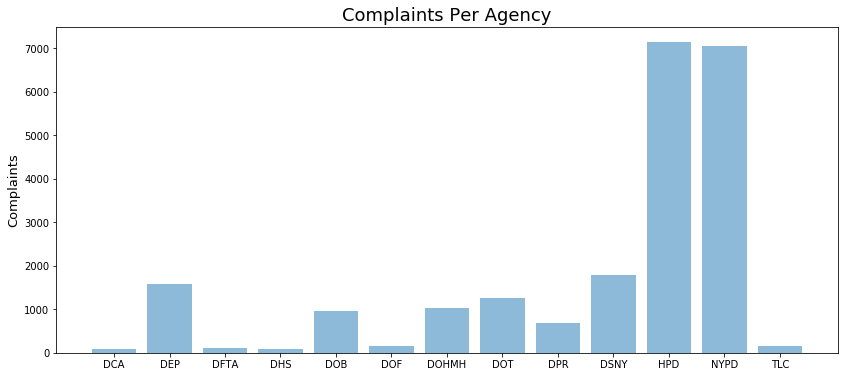

In [177]:
plot_complaints_per_agency(bedstuy)

In [367]:
group_by_complaint_type(bedstuy)

There are 138 different complaint types of which 90 have at least 10 complaints.
----------
                         Number_of_Calls
Noise - Residential                 2608
HEAT/HOT WATER                      2211
Noise - Commercial                  1617
Noise - Street/Sidewalk              999
UNSANITARY CONDITION                 997
PAINT/PLASTER                        811
Rodent                               739
PLUMBING                             636
Illegal Parking                      597
Sanitation Condition                 594



        DESCRIPTIVE STATISTICS ON # OF COMPLAINTS PER DAY:        #_of_Complaints
count       365.000000
mean         60.531507
std          17.492140
min           1.000000
25%          48.000000
50%          59.000000
75%          71.000000
max         137.000000
DAYS WITH THE MOST COMPLAINTS:             #_of_Complaints
2016-06-25              137


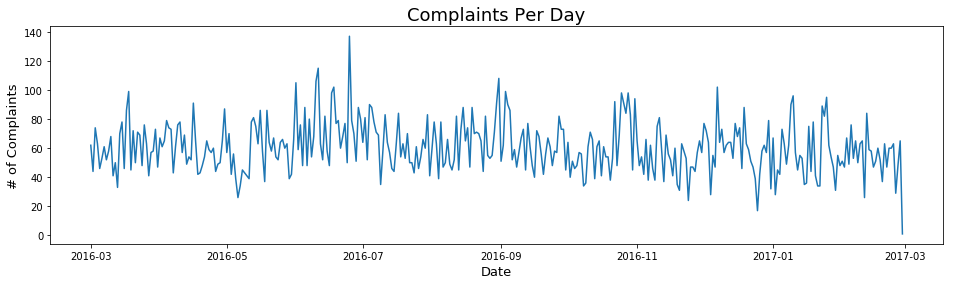

In [23]:
complaints_per_day(bedstuy)

As seen below, the Bed-Stuy zip code 11216 also has a dip in complaints on Sunday, but Wednesday is close to the mean (60.53), not high like in downtown BK, and Saturday is above the mean, not much lower like in downtown BK. This is probably because downtown BK has more jobs, meaning more people and traffic and complaints during weekdays, while Bed-Stuy is more residential.

In [24]:
day_of_week(bedstuy)

,ave_complaints
Monday,63.076923
Tuesday,61.377358
Wednesday,60.230769
Thursday,59.634615
Friday,63.653846
Saturday,61.019231
Sunday,54.711538


## Comparing demographics of zip codes 11216 & 11201

Got demographics for October 2017 from www.zip-codes.com

In [213]:
demo1 = pd.DataFrame(columns=['zip', "income", 'pop', "whitepop", 'perc_white', 'median_age', 'res', 'biz', \
                             'perc_biz', 'area', 'complaints', 'complaints_per_capita', 'mean_days_response_time'], \
                     data=[[11216, 47107, 49071, 7847, 0, 34, 21243, 1338, 0, 0.935, len(bedstuy), 0, 9.1617]])

demo2 = pd.DataFrame(columns=['zip', "income", 'pop', "whitepop", 'perc_white', 'median_age', 'res', 'biz', \
                             'perc_biz', 'area', 'complaints', 'complaints_per_capita', 'mean_days_response_time'], \
                     data=[[11201, 101150, 61165, 35835, 0, 35.70, 31207, 3113, 0, 1.421, len(data), 0, 8.917]])

demo = pd.concat([demo1, demo2], axis=0, ignore_index=True)

demo['perc_white'] = demo['whitepop'] / demo['pop']
demo['perc_biz'] = demo['biz'] / (demo['biz'] + demo['res'])
demo['pop_density'] = demo['pop'] / demo['area'] # people per square mile
demo['complaints_per_capita'] = demo['complaints'] / demo['pop']

demo

,zip,income,pop,whitepop,perc_white,median_age,res,biz,perc_biz,area,complaints,complaints_per_capita,mean_days_response_time,pop_density
0,11216,47107,49071,7847,0.159911,34.0,21243,1338,0.059253,0.935,22094,0.450246,9.1617,52482.352941
1,11201,101150,61165,35835,0.585874,35.7,31207,3113,0.090705,1.421,16371,0.267653,8.9170,43043.631246


As seen above, downtown BK has more than twice the household income of my neighborhood, many more white people (not surprising), slightly more businesses (it's a mini Central Business District so that makes sense), lower population density, and fewer complaints per capita. The last two points surprise me. I was under the impression that wealthier people tend to use 311 more (need to assess the citywide universe of data to really assess this relationship). The lower population density is probably because so much space is taken up in downtown Brooklyn by offices, including government agencies. Response time is not appreciably different between the two zip codes.

# 7. Repeating descriptive statistics calculations with full universe of 311 data for all zip codes (still Mar 16 through Feb 2017)

## Importing demographic data by zip code

This table of demographic data per zip code is unusable for actual professional analysis because so few people are surveyed per zip code (see "Count Participants" column). However, this dataset is provided by both NYC and data.gov, and I didn't find a better one, so I'm using it to demonstrate the analytical methods.

In [245]:
demographics = pd.read_csv('data/Demographic_Statistics_By_Zip_Code.csv')
demographics.rename(columns={'JURISDICTION NAME': 'zip_code'}, inplace=True)
demographics['zip_code'] = demographics['zip_code'].astype(str)
demographics.drop(['COUNT OTHER CITIZEN STATUS',
       'PERCENT OTHER CITIZEN STATUS', 'COUNT CITIZEN STATUS UNKNOWN', 'PERCENT CITIZEN STATUS UNKNOWN', 
        'COUNT CITIZEN STATUS TOTAL', 'PERCENT CITIZEN STATUS TOTAL', 'COUNT RECEIVES PUBLIC ASSISTANCE', 
                   'COUNT NRECEIVES PUBLIC ASSISTANCE', 
        'PERCENT NRECEIVES PUBLIC ASSISTANCE', 'COUNT PUBLIC ASSISTANCE UNKNOWN', 'PERCENT PUBLIC ASSISTANCE UNKNOWN',
       'COUNT PUBLIC ASSISTANCE TOTAL', 'PERCENT PUBLIC ASSISTANCE TOTAL', 'COUNT PACIFIC ISLANDER',
       'COUNT MALE', 'COUNT FEMALE', 'COUNT GENDER UNKNOWN', 'COUNT GENDER TOTAL',
       'COUNT HISPANIC LATINO', 'COUNT AMERICAN INDIAN', 'COUNT ASIAN NON HISPANIC', 
        'COUNT WHITE NON HISPANIC', 'COUNT BLACK NON HISPANIC', 'COUNT OTHER ETHNICITY', 
        'COUNT ETHNICITY UNKNOWN', 'COUNT ETHNICITY TOTAL', 'COUNT PERMANENT RESIDENT ALIEN', 
        'COUNT US CITIZEN'], axis=1, inplace=True)
demographics.head(3)

,zip_code,COUNT PARTICIPANTS,PERCENT FEMALE,PERCENT MALE,PERCENT GENDER UNKNOWN,PERCENT GENDER TOTAL,PERCENT PACIFIC ISLANDER,PERCENT HISPANIC LATINO,PERCENT AMERICAN INDIAN,PERCENT ASIAN NON HISPANIC,PERCENT WHITE NON HISPANIC,PERCENT BLACK NON HISPANIC,PERCENT OTHER ETHNICITY,PERCENT ETHNICITY UNKNOWN,PERCENT ETHNICITY TOTAL,PERCENT PERMANENT RESIDENT ALIEN,PERCENT US CITIZEN,PERCENT RECEIVES PUBLIC ASSISTANCE
0,10001,44,0.50,0.50,0,100,0.0,0.36,0.0,0.07,0.02,0.48,0.07,0.0,100,0.05,0.95,0.45
1,10002,35,0.54,0.46,0,100,0.0,0.03,0.0,0.80,0.17,0.00,0.00,0.0,100,0.06,0.94,0.06
2,10003,1,1.00,0.00,0,100,0.0,0.00,0.0,1.00,0.00,0.00,0.00,0.0,100,0.00,1.00,0.00


In [187]:
len(demographics['zip_code'].unique())

236

In [349]:
zip_list = demographics['zip_code'].unique()

236

#### There are 480 NYC zip codes according to https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php while there are only 236 in the demographic data and 456 unique "Incident Zips" in the 311 data. According to https://www.zip-codes.com/city/ny-new-york.asp there are 145 in Manhattan, 47 in Brooklyn, 78 in Queens, 25 in Bronx, and 14 in Staten Island - totally 309. According to Google there are 160. The next cell takes the average of the estimates (excluding the 456 number that still includes bad values in the 'Incident Zip' column).

In [190]:
zip_count = (len(demographics['zip_code'].unique()) + 480 + 309 + 160) / 4
zip_count

296.25

## Importing data for 311 complaints throughout NYC

In [351]:
city = pd.read_csv('data/311_all_Mar16_Feb17.csv')
print("There were", len(city), "complaints in NYC between March 1, 2016 and February 28, 2017.")
city.drop(['Agency Name', 'Location Type', 'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough',
       'School Name', 'School Number', 'School Region', 'School Code',
       'School Phone Number', 'School Address', 'School City', 'School State',
       'School Zip', 'School Not Found', 'School or Citywide Complaint',
       'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location',
       'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp',
       'Bridge Highway Segment', 'Garage Lot Name', 'Ferry Direction',
       'Ferry Terminal Name', 'Location'], axis=1, inplace=True)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (8,17,40,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There were 2338257 complaints in NYC between March 1, 2016 and February 28, 2017.


In [353]:
city['Created Date'] = pd.to_datetime(city['Created Date'])

In [356]:
city['Closed Date'] = pd.to_datetime(city['Closed Date'], errors='coerce')

In [357]:
city.sort_values(by='Closed Date', axis=0, ascending=False, inplace=True)

In [358]:
print(len(city['Incident Zip'].unique()))

1013


In [359]:
city['response_time'] = city['Closed Date'] - city['Created Date']

## Running descriptive analyses on citywide 311 data

In [360]:
response_stats(city)

DESCRIPTIVE STATS FOR THE RAW DATA:
count                     2273352
mean       8 days 13:51:22.817900
std      220 days 13:26:33.353140
min         -42444 days +23:31:27
25%               0 days 02:36:00
50%               1 days 00:00:00
75%               6 days 00:00:00
max            1176 days 18:23:07
Name: response_time, dtype: object
--------
DESCRIPTIVE STATS FOR THE CLEANED DATA:
count                    2160334
mean     10 days 08:47:05.907145
std      31 days 08:46:49.434007
min              0 days 00:00:01
25%              0 days 03:24:00
50%              1 days 02:32:00
75%       6 days 13:28:36.250000
max            590 days 23:46:02
Name: response_time, dtype: object
--------
There were 1 upper outliers removed.
There were 24208 rows removed with response times below zero.


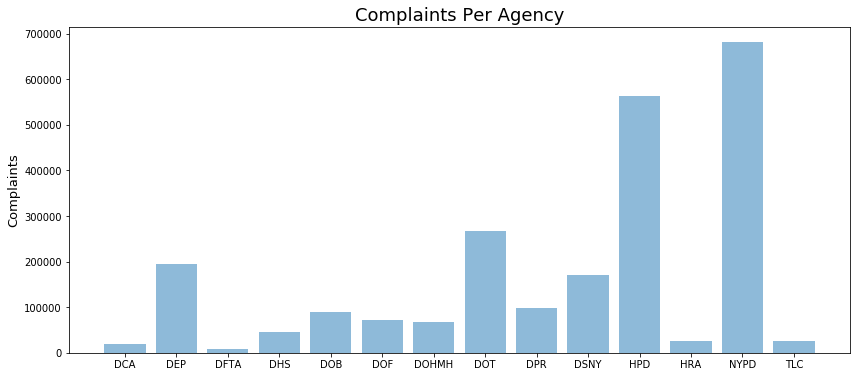

In [361]:
plot_complaints_per_agency(city)

In [368]:
group_by_complaint_type(city)

There are 250 different complaint types of which 220 have at least 10 complaints.
----------
                         Number_of_Calls
Noise - Residential               224427
HEAT/HOT WATER                    198219
Illegal Parking                   126162
Blocked Driveway                  120563
Street Condition                   90790
Street Light Condition             86173
UNSANITARY CONDITION               79954
Water System                       71615
Noise - Street/Sidewalk            62161
PAINT/PLASTER                      59686


DESCRIPTIVE STATISTICS ON # OF COMPLAINTS PER DAY:        #_of_Complaints
count       365.000000
mean       6406.183562
std        1090.192108
min         135.000000
25%        5604.000000
50%        6606.000000
75%        7095.000000
max        9928.000000
--------
DAY(S) WITH THE MOST COMPLAINTS:             #_of_Complaints
2017-01-09             9928


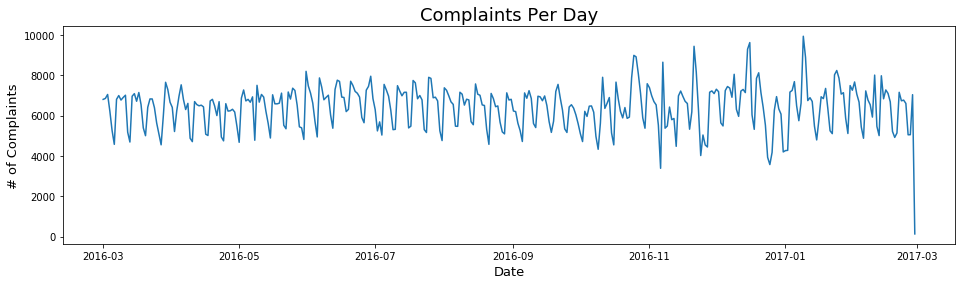

In [362]:
complaints_per_day(city)

The time series above may look different from others because there are 0 values in the df because of the faulty zip code labels that I removed. This left some days without any values. A good next step would be to figure out a way to visualize the data without connecting the 0 values with lines, probably using a mask like this example (after converting 0s to NaNs): https://stackoverflow.com/questions/14399689/matplotlib-drawing-lines-between-points-ignoring-missing-data

In [363]:
day_of_week(city)

,ave_complaints
Monday,6948.423077
Tuesday,7065.018868
Wednesday,6932.884615
Thursday,6777.269231
Friday,6601.519231
Saturday,5422.865385
Sunday,5082.634615


# 8. Calculations on zip codes throughout NYC

The next cell is an attempt to clean up the data and remove rows without usable values in the 'Incident Zip' column. It reduces the number of observations a lot, from 2,338,257 to 887,876.

In [369]:
city['Incident Zip'] = city['Incident Zip'].astype(str)        
mask = (city['Incident Zip'].str.len() == 5)
city_clean1 = city.loc[mask]
len(city_clean1)

887876

In [370]:
city_clean2 = city[city['Incident Zip'].isin(zip_list)]
len(city_clean2)

873655

## Calculating average complaints per day per zip code

In [192]:
6406.183562 / zip_count # 6406 complaints per day taken from output of complaints_per_day() function above

21.624248310548523

## Calculating complaints per zip code

In [373]:
perzip1 = city_clean2.groupby('Incident Zip')
perzip = pd.DataFrame(perzip1['Unique Key'].apply(np.size))
# add average response time per zip to df
    # perzip = pd.DataFrame(perzip1['Unique Key'].apply(np.size), perzip1['response_time'].apply(np.mean))
perzip.rename(columns = {'Unique Key':'Number_of_Calls'}, inplace = True)
perzip['zip_code'] = perzip.index
perzip = perzip[perzip['Number_of_Calls']>45] # this was chosen because the next row with value 44 was a faulty zip.
perzip.sort_values(by='Number_of_Calls', axis=0, ascending=False, inplace=True)
perzip.index.name = None

print("There are", len(perzip), "zip codes remaining after cleaning. The average # of calls among these is",
     np.mean(perzip['Number_of_Calls']), "or", np.mean(perzip['Number_of_Calls'])/365, "per day.")
perzip.tail()

There are 172 zip codes remaining after cleaning. The average # of calls among these is 5078.883720930233 or 13.914749920356803 per day.


,Number_of_Calls,zip_code
11001,350,11001
10280,251,10280
10020,163,10020
10044,126,10044
10119,57,10119


The analysis above resulted in a different average call per day per zip code than we got above because we used a different estimate for the number of real zip codes. Actual value is probably between 13 and 21 calls per day per zip.

## Calculating average response time per zip code

In [372]:
resper1 = city_clean2['response_time'].groupby(city_clean2['Incident Zip'])
resper1.describe()

,count,mean,std,min,25%,50%,75%,max
Incident Zip,,,,,,,,
10001,5638,8 days 06:04:36.249201,24 days 11:10:49.107738,-41 days +00:00:00,0 days 01:19:59,0 days 13:25:24.500000,5 days 14:08:36,361 days 13:14:39
10002,7247,10 days 07:12:29.732716,30 days 14:52:43.244975,-119 days +00:00:00,0 days 01:26:08,0 days 13:15:00,6 days 01:52:24.500000,419 days 12:42:50
10003,8138,9 days 00:02:54.477021,28 days 21:06:57.344838,-94 days +00:00:00,0 days 02:00:01.750000,0 days 16:27:33.500000,5 days 03:22:40.500000,485 days 09:24:33
10004,929,6 days 15:33:27.587728,24 days 03:50:37.107034,-25 days +07:19:00,0 days 01:23:31,0 days 08:26:17,4 days 14:30:00,464 days 14:53:00
10005,1039,5 days 22:24:50.753609,17 days 17:27:14.454518,-4 days +11:40:00,0 days 01:25:43.500000,0 days 15:15:00,5 days 00:27:00,339 days 02:35:00
10006,615,6 days 10:12:36.624390,19 days 22:41:20.253773,-3 days +11:33:00,0 days 02:48:05.500000,0 days 19:34:26,4 days 23:41:13.500000,282 days 01:17:00
10007,1492,7 days 06:54:30.901474,24 days 13:03:13.697042,-77 days +00:00:00,0 days 01:20:45.250000,0 days 06:13:06.500000,4 days 07:25:45,365 days 06:14:41
10009,6719,7 days 19:17:54.214764,24 days 20:01:50.528152,-87 days +00:00:00,0 days 02:20:10.500000,0 days 18:21:00,5 days 03:19:22,372 days 08:45:32
10010,3168,9 days 04:27:45.201388,23 days 09:38:31.170999,-83 days +00:00:00,0 days 02:18:12,1 days 05:30:24.500000,7 days 07:33:15,442 days 00:28:00


# 9. Who uses 311?

## Merging demographic data per zip with complaints per zip

In [254]:
zips311 = pd.merge(demographics, perzip, how="inner", on=['zip_code'])
len(zips311)

172

### Narrowing down to just the zip codes with more than half the mean number of count participants because so many had 0 or very small values. It's still too small a sample size per zip for this analysis to be actionable, but at least we can run sample analyses.

In [263]:
zips311 = zips311[zips311['COUNT PARTICIPANTS'] > 9]
len(zips311)

42

In [266]:
zips311.head(3)

,zip_code,COUNT PARTICIPANTS,PERCENT FEMALE,PERCENT MALE,PERCENT GENDER UNKNOWN,PERCENT GENDER TOTAL,PERCENT PACIFIC ISLANDER,PERCENT HISPANIC LATINO,PERCENT AMERICAN INDIAN,PERCENT ASIAN NON HISPANIC,PERCENT WHITE NON HISPANIC,PERCENT BLACK NON HISPANIC,PERCENT OTHER ETHNICITY,PERCENT ETHNICITY UNKNOWN,PERCENT ETHNICITY TOTAL,PERCENT PERMANENT RESIDENT ALIEN,PERCENT US CITIZEN,PERCENT RECEIVES PUBLIC ASSISTANCE,Number_of_Calls
0,10001,44,0.50,0.50,0,100,0.0,0.36,0.0,0.07,0.02,0.48,0.07,0.0,100,0.05,0.95,0.45,5840
1,10002,35,0.54,0.46,0,100,0.0,0.03,0.0,0.80,0.17,0.00,0.00,0.0,100,0.06,0.94,0.06,7421
13,10016,17,0.71,0.29,0,100,0.0,0.53,0.0,0.00,0.00,0.47,0.00,0.0,100,0.00,1.00,0.53,6683


## Measuring correlations b/t demographics and # of complaints - all very small

The correlation between PERCENT WHITE NON HISPANIC and Number_of_Calls is 0.0508480520408


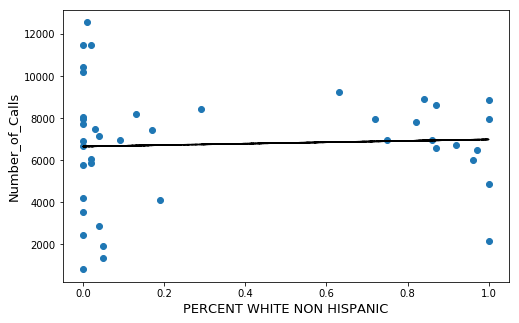

In [268]:
def plot_two_variables(df, column1, column2):
    x = df[column1]
    y = df[column2]
    
    fit = np.polyfit(x,y,1)
    fit_fn = np.poly1d(fit)
    
    plt.figure(figsize=(8,5))
    plt.ylabel(column2, fontsize=13)
    plt.xlabel(column1, fontsize=13) # may need to change this to make it more clear
    plt.plot(x, y, 'o', x, fit_fn(x), '--k')
    
    print("The correlation between", column1, "and", column2, "is", (x).corr(y))
    
plot_two_variables(zips311, 'PERCENT WHITE NON HISPANIC', 'Number_of_Calls')

The correlation between PERCENT FEMALE and Number_of_Calls is 0.0308966367744


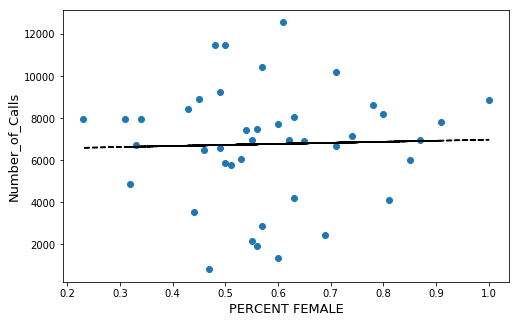

In [269]:
plot_two_variables(zips311, 'PERCENT FEMALE', 'Number_of_Calls')

The correlation between PERCENT US CITIZEN and Number_of_Calls is -0.00651564100635


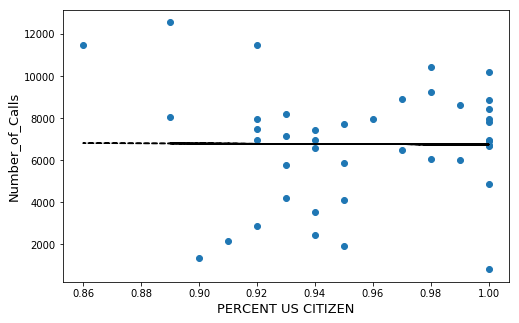

In [270]:
plot_two_variables(zips311, 'PERCENT US CITIZEN', 'Number_of_Calls')

The correlation between PERCENT RECEIVES PUBLIC ASSISTANCE and Number_of_Calls is -0.0931438017082


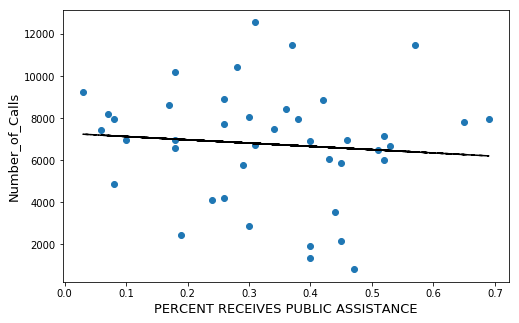

In [271]:
plot_two_variables(zips311, 'PERCENT RECEIVES PUBLIC ASSISTANCE', 'Number_of_Calls')

## The above results aren't actionable, but the code could be run on better data about demographics per zip code and you'd have useful insights about who uses 311.